In [21]:
!pip install google-play-scraper

In [23]:
from google_play_scraper import reviews, Sort
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
# 1. Скачиваем 10000 свежих отзывов
result_rus, _ = reviews(
    'air.ru.crazypanda.wpcm',
    lang='ru',
    sort=Sort.NEWEST,
    count=10000
)
result_eng, _ = reviews(
    'air.ru.crazypanda.wpcm',
    lang='en',
    sort=Sort.NEWEST,
    count=10000
)
# 2. Превращаем в таблицу pandas
dfr = pd.DataFrame(result_rus)
dfe = pd.DataFrame(result_eng)

Убираю ненужные для моего исследования столбцы.

Ставлю 3 задачи для анализа:
1. Построить графики оценок в зависимости от времени для русско и англо-говорящих групп.  это позволит увидеть изменение отзывов пользователей с течением времени, покажет есть ли перекосы в пользу той, или иной группы ( или насколько успешно игра локализуется)

2. Посмотреть средние оценки по версиям приложений.
3. Попробовать выборочно отобрать и изучить случайные комментарии, выделить + и - игры.

In [25]:
eng_poker = dfe.drop(columns=['userImage', 'reviewId','replyContent','repliedAt','userName'])
rus_poker = dfr.drop(columns=['userImage', 'reviewId','replyContent','repliedAt','userName'])
eng_poker.to_excel("PokerGameEng.xlsx")
rus_poker.to_excel("PokerGameRus.xlsx")

In [27]:
eng_poker['at'] = pd.to_datetime(eng_poker['at'], errors='coerce')
eng_poker['date'] = eng_poker['at'].dt.date
rus_poker['at'] = pd.to_datetime(eng_poker['at'], errors='coerce')
rus_poker['date'] = eng_poker['at'].dt.date

# группируем по дате и считаем среднее значение оценок
daily_avg_eng = eng_poker.groupby('date')['score'].mean().reset_index()
print(daily_avg_eng)
daily_avg_rus = rus_poker.groupby('date')['score'].mean().reset_index()
print(daily_avg_rus)

            date  score
0     2014-02-13    5.0
1     2014-02-17    5.0
2     2014-02-21    5.0
3     2014-02-24    3.0
4     2014-03-03    5.0
...          ...    ...
2520  2025-09-13    5.0
2521  2025-09-22    5.0
2522  2025-09-23    1.0
2523  2025-09-24    1.0
2524  2025-10-03    1.0

[2525 rows x 2 columns]
            date  score
0     2014-02-13    1.0
1     2014-02-17    2.0
2     2014-02-21    2.0
3     2014-02-24    5.0
4     2014-03-03    4.0
...          ...    ...
2520  2025-09-13    3.0
2521  2025-09-22    1.0
2522  2025-09-23    5.0
2523  2025-09-24    1.0
2524  2025-10-03    1.0

[2525 rows x 2 columns]


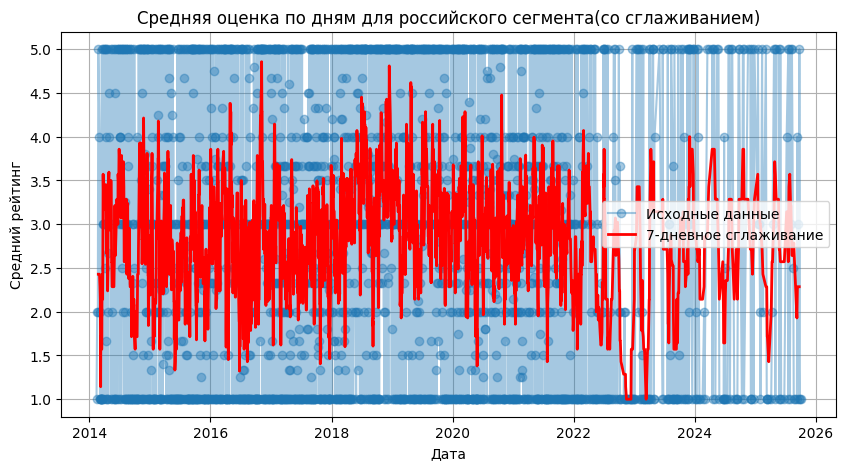

In [28]:
daily_avg = daily_avg_rus.sort_values('date').copy()
# считаем скользящее среднее
daily_avg['rolling_mean'] = daily_avg['score'].rolling(window=7, center=True).mean()
# --- построение ---
plt.figure(figsize=(10,5))
plt.plot(daily_avg['date'], daily_avg['score'], marker='o', alpha=0.4, label='Исходные данные')
plt.plot(daily_avg['date'], daily_avg['rolling_mean'], color='red', linewidth=2, label='7-дневное сглаживание')
plt.title('Средняя оценка по дням для российского сегмента(со сглаживанием)')
plt.xlabel('Дата')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.grid(True)
plt.show()


Получаем график, по которому можно делать какие-то выводы

(интересно порассуждать почему игра не вышла на пик во время ковида, но это уже для другого анализа)




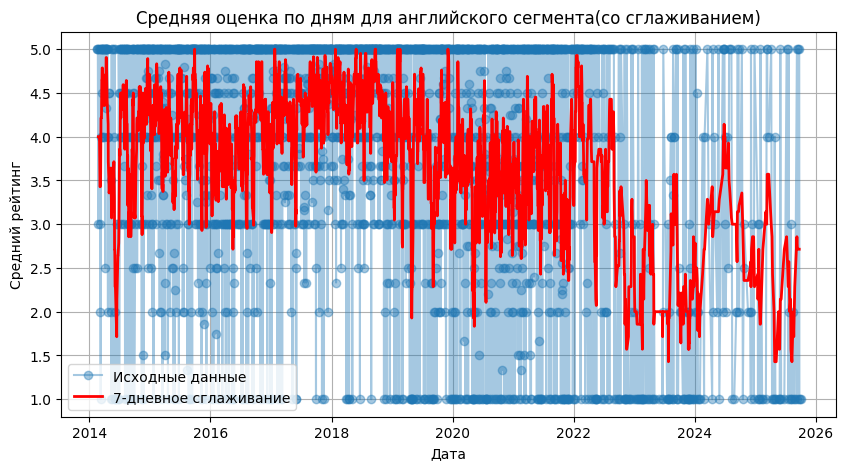

In [29]:
daily_avg = daily_avg_eng.sort_values('date').copy()
# считаем скользящее среднее
daily_avg['rolling_mean'] = daily_avg['score'].rolling(window=7, center=True).mean()
# --- построение ---
plt.figure(figsize=(10,5))
plt.plot(daily_avg['date'], daily_avg['score'], marker='o', alpha=0.4, label='Исходные данные')
plt.plot(daily_avg['date'], daily_avg['rolling_mean'], color='red', linewidth=2, label='7-дневное сглаживание')

plt.title('Средняя оценка по дням для английского сегмента(со сглаживанием)')
plt.xlabel('Дата')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.grid(True)
plt.show()


Можно разглядеть расхождение в графиках оценок для российской и англоязычной аудиторий. Посмотрим на дистанции одного года.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


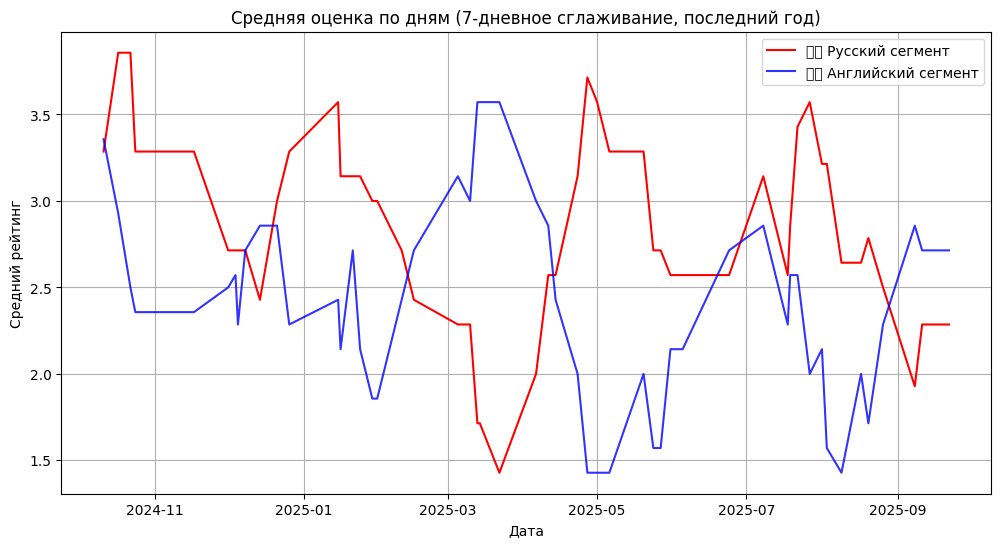

In [30]:
def prepare_daily_avg(df):
    # убеждаемся, что дата правильная
    df['at'] = pd.to_datetime(df['at'], errors='coerce')
    df['date'] = df['at'].dt.date
    # группировка по дням
    daily_avg = df.groupby('date')['score'].mean().reset_index()
    daily_avg['date'] = pd.to_datetime(daily_avg['date'])
    # сглаживание (7-дневное)
    daily_avg['rolling_mean'] = daily_avg['score'].rolling(window=7, center=True).mean()
    return daily_avg

# применяем к обоим наборам
rus_daily = prepare_daily_avg(rus_poker)
eng_daily = prepare_daily_avg(eng_poker)

# выравниваем даты (чтобы не было пробелов)
min_date = max(rus_daily['date'].min(), eng_daily['date'].min())
max_date = min(rus_daily['date'].max(), eng_daily['date'].max())
rus_daily = rus_daily[(rus_daily['date'] >= min_date) & (rus_daily['date'] <= max_date)]
eng_daily = eng_daily[(eng_daily['date'] >= min_date) & (eng_daily['date'] <= max_date)]

# --- фильтрация за последний год ---
end_date = max_date
start_date = end_date - pd.Timedelta(days=365)

rus_daily = rus_daily[(rus_daily['date'] >= start_date) & (rus_daily['date'] <= end_date)]
eng_daily = eng_daily[(eng_daily['date'] >= start_date) & (eng_daily['date'] <= end_date)]

# --- построение графика ---
plt.figure(figsize=(12,6))
plt.plot(rus_daily['date'], rus_daily['rolling_mean'], color='red', label='🇷🇺 Русский сегмент')
plt.plot(eng_daily['date'], eng_daily['rolling_mean'], color='blue', label='🇬🇧 Английский сегмент', alpha=0.8)

plt.title('Средняя оценка по дням (7-дневное сглаживание, последний год)')
plt.xlabel('Дата')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.grid(True)
plt.show()


 Что видно из графика:

У русского сегмента (красная линия) пики приходятся на те же даты, где английский сегмент (синяя линия) проваливается, и наоборот.

Колебания синхронны по фазе, но противоположны по знаку — т.е. в одни и те же периоды пользователи двух языковых групп реагируют по-разному.

Предположим, что может вызывать этот эффект:

1) Тестирование фич (A/B rollout)

2) Разница в сезонах и событиях.
Некоторые пики могут быть связаны с:

Рекламными кампаниями или турнирами (возможно, разное время проведения).

Праздниками — например, Рождество/Новый год у разных культур.

3) Культурные отличия
4) Состав аудитории ( но это можно связать с реклмаными компаниями ( если рекламируем через какие-нибудь ufc events, то будем получать мужскую аудиторию), или же с культурными отличиями ( для американцев покер это что-то родное, в то время как в Росии покер становится популярным из-за западной культуры только сейчас)

In [37]:
# средние оценки по версиям приложения
rus_by_version = rus_poker.groupby('appVersion')['score'].mean().reset_index().sort_values('appVersion', ascending=True)
eng_by_version = eng_poker.groupby('appVersion')['score'].mean().reset_index().sort_values('appVersion', ascending=True)
# переименуем колонки для удобства
rus_by_version.columns = ['appVersion', 'avg_score_rus']
eng_by_version.columns = ['appVersion', 'avg_score_eng']
rus_by_version.to_excel("Rus_Poker_Game_ScoreValue.xlsx")
eng_by_version.to_excel("Eng_Poker_Game_ScoreValue.xlsx")

/tmp/ipython-input-3249285071.py:15: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3249285071.py:15: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


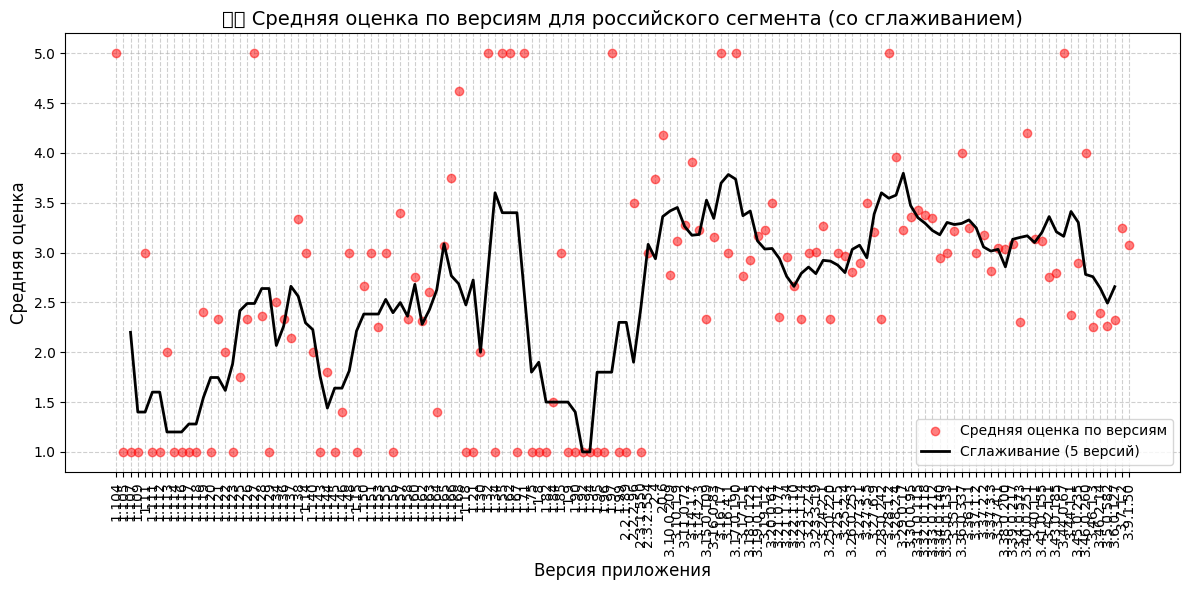

In [32]:
rus_by_version = rus_by_version.sort_values('appVersion')
# Добавляем скользящее среднее
rus_by_version['rolling_mean'] = rus_by_version['avg_score_rus'].rolling(window=5, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(rus_by_version['appVersion'], rus_by_version['avg_score_rus'], 'o', color='red', alpha=0.5, label='Средняя оценка по версиям')
plt.plot(rus_by_version['appVersion'], rus_by_version['rolling_mean'], color='black', linewidth=2, label='Сглаживание (5 версий)')

plt.title('🇷🇺 Средняя оценка по версиям для российского сегмента (со сглаживанием)', fontsize=14)
plt.xlabel('Версия приложения', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-4202672437.py:15: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4202672437.py:15: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


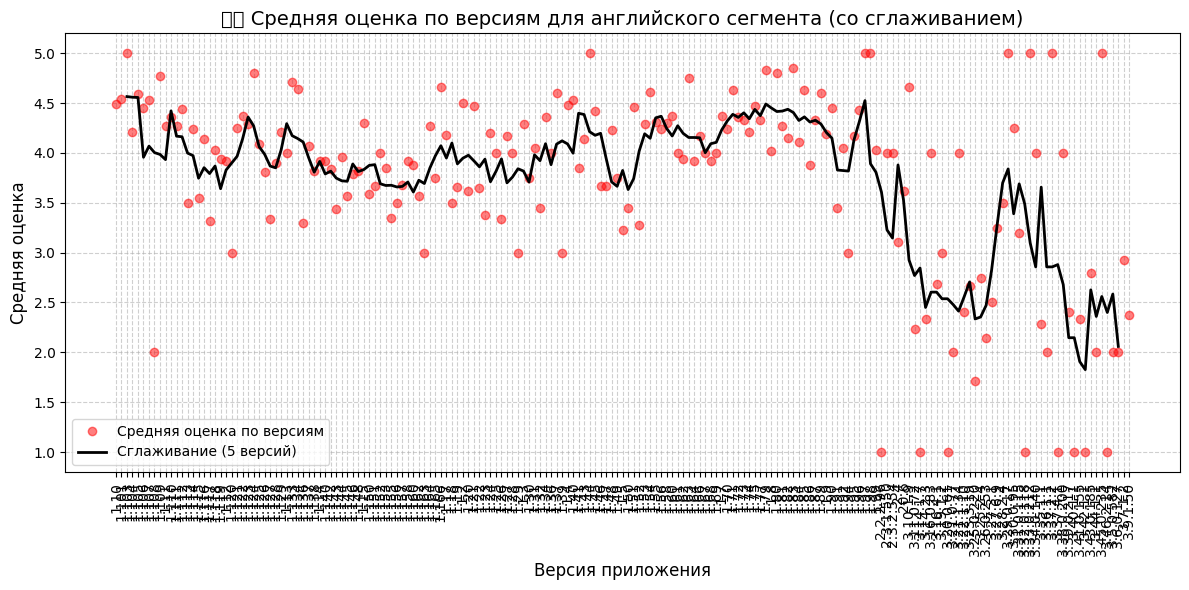

In [33]:
eng_by_version = eng_by_version.sort_values('appVersion')
# Добавляем скользящее среднее
eng_by_version['rolling_mean'] = eng_by_version['avg_score_eng'].rolling(window=5, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(eng_by_version['appVersion'], eng_by_version['avg_score_eng'], 'o', color='red', alpha=0.5, label='Средняя оценка по версиям')
plt.plot(eng_by_version['appVersion'], eng_by_version['rolling_mean'], color='black', linewidth=2, label='Сглаживание (5 версий)')

plt.title('🇷🇺 Средняя оценка по версиям для английского сегмента (со сглаживанием)', fontsize=14)
plt.xlabel('Версия приложения', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Что мы видим:

В русском сегменте есть версии 1.104, 1.71, 3.28.1.2, 3.44.0.67 и т.д., которых нет в английском сегменте.

В английском сегменте есть версии 1.103, 3.37.2.2, 3.33.0.212, 3.45.0.235 и т.д., которых нет в русском сегменте.

Это может значить несколько вещей:

1) Локализация релизов — разные языковые версии выходят в разное время.

2) A/B тестирование или этапы тестов — разные рынки могут получать разные билды.

3) Региональные багфиксы — отдельные версии создаются только для одного сегмента.

4) Разница в коде или функционале — возможно, версии отличаются не только номером, но и функционально.

Вывод:
Судя по данным, обновления игры выходят для разных регионов в разное время. Возможно, это связано с тем, что на какой-то аудитории обкатывают фичу, а на другой ("более целевой") ее реализуют ( или нет).

In [34]:
result_korean_poker, _ = reviews(
    'com.wonderpeople.megahitpoker.global',
    lang='en',
    sort=Sort.NEWEST,
    count=100000
)
# 2. Превращаем в таблицу pandas
dfk = pd.DataFrame(result_korean_poker)


In [ ]:
korean_poker = dfk.drop(columns=['userImage', 'reviewId','replyContent','repliedAt','userName'])

,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,good poker app,5,0,4.1.1,2025-10-08 19:42:41,4.1.1
1,it gets you ready to sit down at a table to wi...,5,0,4.0.6,2025-10-08 18:18:36,4.0.6
2,Loving Interesting Wonderful Thumbs Up Game......,5,0,4.1.1,2025-10-08 11:37:47,4.1.1
3,I love it,1,0,4.1.1,2025-10-08 11:30:31,4.1.1
4,one word AWESOME,5,0,4.1.1,2025-10-08 09:03:38,4.1.1
...,...,...,...,...,...,...
33969,Game was awesome for one day now it just freez...,1,1,None,2017-07-31 21:48:28,None
33970,Great game,5,2,None,2017-07-27 01:00:52,None
33971,Never loaded,1,5,1.4.0,2017-07-26 14:24:42,1.4.0
33972,Love it,5,3,1.2.1.2,2017-07-26 08:12:39,1.2.1.2


In [36]:
kor_by_version = korean_poker.groupby('appVersion')['score'].mean().reset_index().sort_values('appVersion', ascending=True)
kor_by_version.columns = ['appVersion', 'avg_score_kor']
kor_by_version.to_excel("Mega_Hit_ScoreValue.xlsx")

/tmp/ipython-input-2739897598.py:16: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2739897598.py:16: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


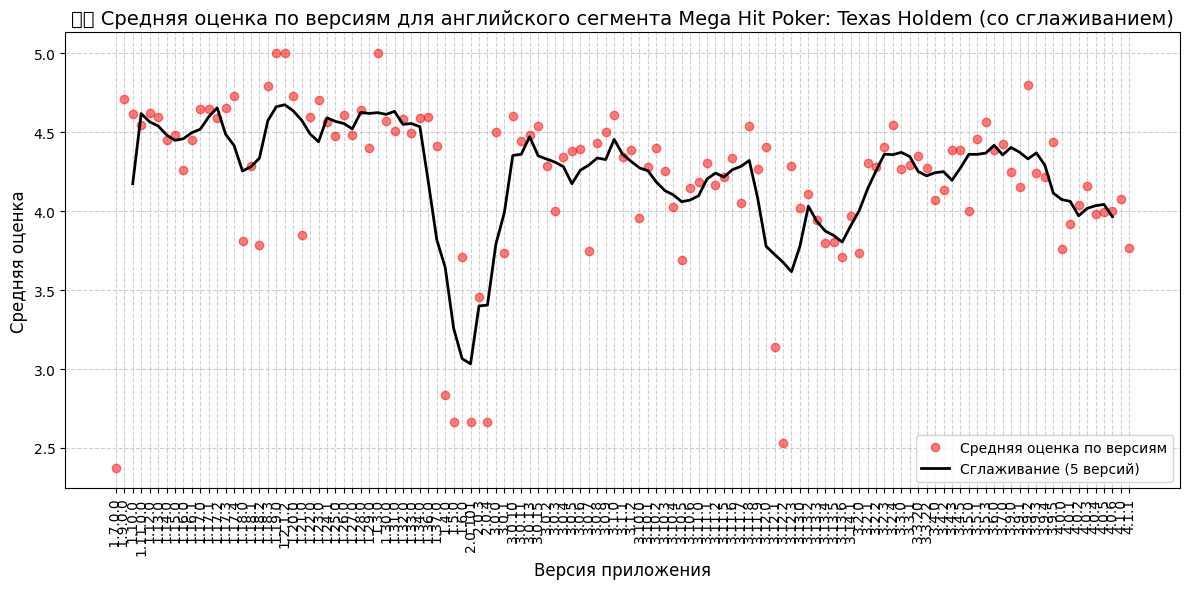

In [ ]:
kor_by_version = kor_by_version.sort_values('appVersion')
# Добавляем скользящее среднее
kor_by_version['rolling_mean'] = kor_by_version['avg_score_kor'].rolling(window=5, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(kor_by_version['appVersion'], kor_by_version['avg_score_kor'], 'o', color='red', alpha=0.5, label='Средняя оценка по версиям')
plt.plot(kor_by_version['appVersion'], kor_by_version['rolling_mean'], color='black', linewidth=2, label='Сглаживание (5 версий)')

plt.title('🇷🇺 Средняя оценка по версиям для английского сегмента Mega Hit Poker: Texas Holdem (со сглаживанием)', fontsize=14)
plt.xlabel('Версия приложения', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Вывод: оценивая игру по отзывам клиентов, можно сделать вывод что у конкурентов дела лучше, более того, они работают "стабиьнее": после выхода обновлений оценки их игры не так резко падают, но и не так резко возрастают. Возможно это связано с более плавной стратегией и не такими резкими изменениями, вносимыми в игру.

Итог: были исследованы отзывы на игру "Poker Game: World Poker Club".
Что я обнаружил:

1) Различие динамики между языковыми сегментами.
Возможно это объясняется проведением независимых релизов, A/B-тестами, культурными различиями.

2)Русский сегмент — демонстрирует улучшение отзывов и выход на стабильное плато в районе 3.0–3.5 баллов. Это может указывать на рост качества продукта и постепенное формирование лояльной аудитории.

3)Английский сегмент — напротив, показывает постепенное снижение удовлетворённости с 4.5 до примерно 2.0 баллов. Это сигнал о нарастающих проблемах с качеством релизов, адаптацией или восприятием изменений пользователями.

4) Из всего вышесказанного можно предположить что у разработчиков больше ориентация на русскоязычную аудиторию.

5) В сравнении с конкурентами (игра Mega Hit Poker: Texas Holdem), стратегия обновлений выглядит менее стабильной, с резкими колебаниями оценок — стоит стремиться к плавным итерациям и постепенному внедрению изменений.

В целом, получение данных по API и дальнейшая их обработка получилась.

В конце хотелось бы добавить, что я хотелось бы написать модель нейронной сети, которая бы обработала комментарии, но пока я это не умею (но я быстро учусь и уверен что сделаю это в течении 2х месяцев!)

